# 网络流量恶意攻击检测分析

## 1. 数据加载与探索分析

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据
df = pd.read_csv('data/train_data.csv')
print(f"数据形状: {df.shape}")
df.head()

数据形状: (157808, 44)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,1,0.000005,udp,-,INT,2,0,168,0,166666.660400,...,1,1,1,0,0,0,1,1,0,Reconnaissance
1,2,0.000006,ptp,-,INT,2,0,208,0,125000.000200,...,1,1,2,0,0,0,26,2,0,Fuzzers
2,3,0.035881,tcp,-,FIN,60,60,3612,49930,3315.871473,...,1,1,1,0,0,0,4,3,0,Normal
3,4,0.828187,tcp,-,FIN,18,20,992,5620,44.676177,...,1,1,1,0,0,0,1,1,0,Exploits
4,5,0.002413,udp,dns,CON,2,2,142,176,1242.236022,...,1,1,3,0,0,0,1,2,0,Normal


### 数据概览

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157808 entries, 0 to 157807
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 157808 non-null  int64  
 1   dur                157808 non-null  float64
 2   proto              157808 non-null  object 
 3   service            157808 non-null  object 
 4   state              157808 non-null  object 
 5   spkts              157808 non-null  int64  
 6   dpkts              157808 non-null  int64  
 7   sbytes             157808 non-null  int64  
 8   dbytes             157808 non-null  int64  
 9   rate               157808 non-null  float64
 10  sttl               157808 non-null  int64  
 11  dttl               157808 non-null  int64  
 12  sload              157808 non-null  float64
 13  dload              157808 non-null  float64
 14  sloss              157808 non-null  int64  
 15  dloss              157808 non-null  int64  
 16  si

### 数值特征统计

In [15]:
df.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
count,157808.000000,157808.000000,157808.000000,157808.000000,1.578080e+05,1.578080e+05,1.578080e+05,157808.000000,157808.000000,1.578080e+05,...,157808.000000,157808.000000,157808.000000,157808.000000,157808.000000,157808.000000,157808.000000,157808.000000,157808.000000,157808.000000
mean,78904.500000,1.365272,20.174376,18.853854,8.708229e+03,1.481530e+04,9.541352e+04,179.512946,79.612510,7.360456e+07,...,6.193476,5.383219,4.207632,8.731813,0.014987,0.014987,0.133257,6.954191,9.101978,0.015715
std,45555.389977,6.504393,133.871953,109.328319,1.705324e+05,1.425454e+05,1.654371e+05,102.944345,110.509985,1.890876e+08,...,8.048967,8.043188,5.786549,10.958752,0.125804,0.125804,0.700504,8.315162,10.760190,0.124372
min,1.000000,0.000000,1.000000,0.000000,2.200000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,39452.750000,0.000005,2.000000,0.000000,1.180000e+02,0.000000e+00,3.277808e+01,62.000000,0.000000,1.304360e+04,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000
50%,78904.500000,0.001609,2.000000,2.000000,4.500000e+02,1.680000e+02,3.222342e+03,254.000000,29.000000,8.799355e+05,...,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000
75%,118356.250000,0.667963,12.000000,10.000000,1.426500e+03,1.100000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,...,7.000000,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000
max,157808.000000,59.999988,9492.000000,10974.000000,1.259439e+07,1.465556e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,...,51.000000,51.000000,46.000000,65.000000,4.000000,4.000000,30.000000,51.000000,62.000000,1.000000


### 类别特征统计

In [16]:
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(f"\n{col}分布:")
    print(df[col].value_counts())


proto分布:
proto
tcp     71969
udp     56953
unas    10885
arp      2572
ospf     2360
        ...  
pipe       82
mtp        82
igmp       17
icmp       15
rtp         1
Name: count, Length: 133, dtype: int64

service分布:
service
-           84771
dns         42542
http        16874
smtp         4552
ftp-data     3568
ftp          3102
ssh          1174
pop3          990
dhcp           85
snmp           66
ssl            49
irc            24
radius         11
Name: count, dtype: int64

state分布:
state
INT    74019
FIN    70033
CON    11848
REQ     1818
RST       75
ECO       12
no         1
PAR        1
URN        1
Name: count, dtype: int64

attack_cat分布:
attack_cat
Normal            50400
Generic           36000
Exploits          30054
Fuzzers           16366
DoS               11038
Reconnaissance     9442
Analysis           1800
Backdoor           1571
Shellcode          1020
Worms               117
Name: count, dtype: int64


### 标签分布

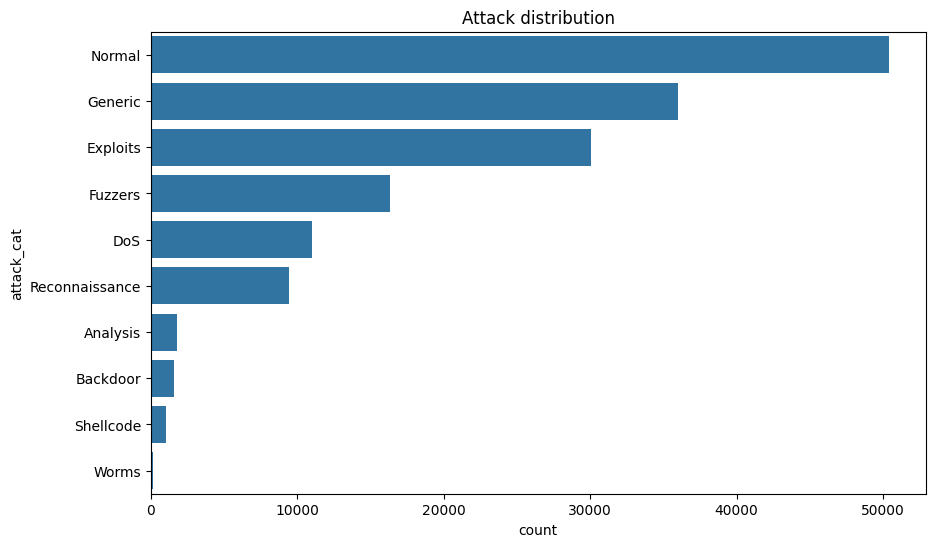

In [21]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, y='attack_cat', order=df['attack_cat'].value_counts().index)
plt.title('Attack distribution')
plt.show()

## 2. 数据预处理

In [22]:
from sklearn.model_selection import train_test_split

# 分离特征和标签
X = df.drop('attack_cat', axis=1)
y = df['attack_cat']

# 划分训练测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")

训练集大小: (126246, 43)
测试集大小: (31562, 43)


## 3. 特征工程

In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 数值特征
numeric_features = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 
                   'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
                   'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb',
                   'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
                   'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
                   'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm',
                   'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd',
                   'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst']

# 类别特征
categorical_features = ['proto', 'service', 'state', 'is_ftp_login', 'is_sm_ips_ports']

# 构建预处理管道
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes',
                                  'rate', 'sttl', 'dttl', 'sload', 'dload',
                                  'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
                                  'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
                                  'tcprtt', 'synack', 'ackdat', 'smean',
                                  'dmean', 'trans_depth', 'response_body_len',
                                  'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', ...]),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['proto', 'service', 'state', 'is_ftp_login',
                                  'is_sm_ips_ports'])])

## 4. 模型训练与评估

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 构建完整模型
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        class_weight='balanced',
        n_jobs=-1))])

# 训练模型
model.fit(X_train, y_train)
print("模型训练完成!")

模型训练完成!


### 模型评估

In [25]:
# 预测测试集
y_pred = model.predict(X_test)

# 分类报告
print("\n=== 分类报告 ===")
print(classification_report(y_test, y_pred))

# 准确率
print("\n=== 准确率 ===")
print(f"准确率: {accuracy_score(y_test, y_pred):.4f}")


=== 分类报告 ===
                precision    recall  f1-score   support

      Analysis       0.38      0.16      0.22       377
      Backdoor       0.32      0.14      0.20       291
           DoS       0.37      0.31      0.33      2232
      Exploits       0.66      0.80      0.72      6031
       Fuzzers       0.73      0.75      0.74      3257
       Generic       1.00      0.98      0.99      7259
        Normal       0.94      0.93      0.93      9979
Reconnaissance       0.85      0.72      0.78      1897
     Shellcode       0.66      0.59      0.62       220
         Worms       0.64      0.37      0.47        19

      accuracy                           0.82     31562
     macro avg       0.65      0.57      0.60     31562
  weighted avg       0.82      0.82      0.82     31562


=== 准确率 ===
准确率: 0.8204


### 特征重要性

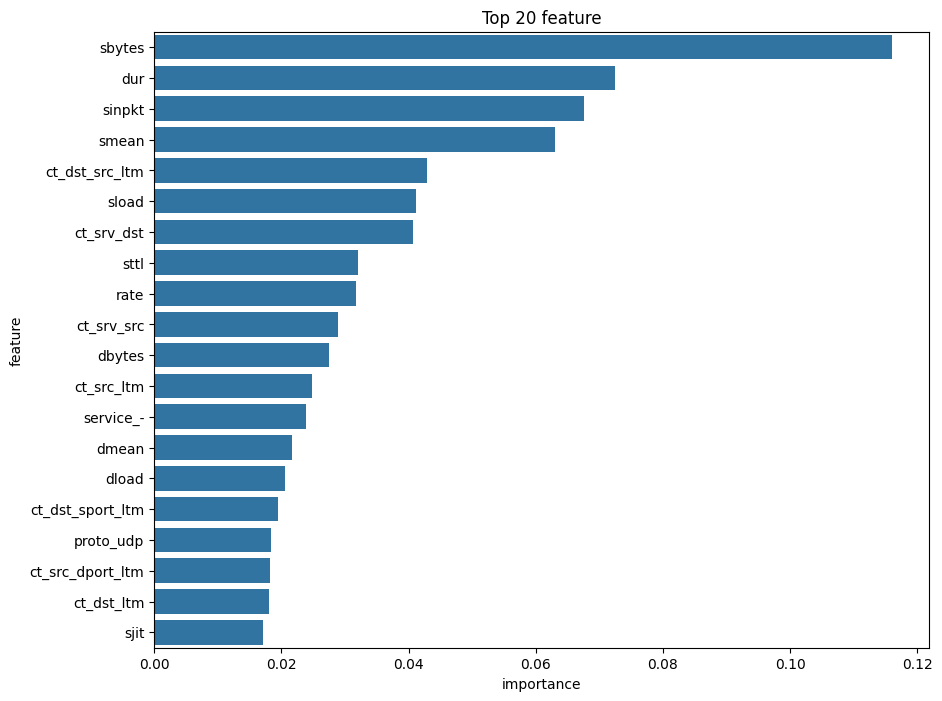

In [27]:
# 获取特征重要性
importances = model.named_steps['classifier'].feature_importances_

# 获取特征名称
numeric_features = model.named_steps['preprocessor'].transformers_[0][2]
categorical_features = model.named_steps['preprocessor'].transformers_[1][2]

# 处理onehot编码后的特征名
ohe = model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(input_features=categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# 创建特征重要性DataFrame
feature_imp = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# 可视化前20个重要特征
plt.figure(figsize=(10,8))
sns.barplot(data=feature_imp.head(20), x='importance', y='feature')
plt.title('Top 20 feature')
plt.show()

## 5. 模型保存

In [28]:
import joblib

# 保存模型
joblib.dump(model, 'traffic_model.pkl')
print("\n模型已保存为 traffic_model.pkl")


模型已保存为 traffic_model.pkl
